In [1]:
# Full ADWIN-based Concept Drift Detection and Evaluation on IoMT IDS Dataset (Enhanced Visualization)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
from river import compose, preprocessing, forest, metrics, drift
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pathlib import Path
import os

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load Dataset CICIoMT2024
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)
            category = file.parents[1].name
            attack = file.parent.name
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'
            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class
            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

train_root = Path('../../../../Data/CICIoMT2024/train')
test_root = Path('../../../../Data/CICIoMT2024/test')
df_train = load_dataset_from_structure(train_root)
df_test = load_dataset_from_structure(test_root)
df = pd.concat([df_train, df_test], ignore_index=True)


In [3]:
# Encode label (attack)
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])

# Feature processing
X = df.drop(['class', 'category_encoded', 'attack', 'attack'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = df['class_encoded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_dicts = pd.DataFrame(X_scaled, columns=X.columns).to_dict(orient='records')
y_values = y.tolist()
dataset = list(zip(X_dicts, y_values))


In [4]:
# Define model
model = compose.Pipeline(
    ('scaler', preprocessing.StandardScaler()),
    ('classifier', forest.ARFClassifier(
        seed=42,
        n_models=20,
        max_features=0.5,
        grace_period=30,
        leaf_prediction='nb'
    ))
)


In [5]:
# Metrics
metric_accuracy = metrics.Accuracy()
metric_precision = metrics.WeightedPrecision()
metric_recall = metrics.WeightedRecall()
metric_f1 = metrics.WeightedF1()

In [6]:
# Drift detector
drift_detector = drift.ADWIN()

# Logging
drift_events = []
metric_logs = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
processing_times, drift_time_per_instance, metrics_time_per_instance = [], [], []
total_time, drift_time_total, metrics_time_total = 0, 0, 0

In [7]:
# Streaming loop
start_time = time.time()
for i, (x, y_true) in enumerate(dataset):
    t_start = time.time()
    y_pred = model.predict_one(x)
    model.learn_one(x, y_true)

    t_metrics = time.time()
    metric_accuracy.update(y_true, y_pred)
    metric_precision.update(y_true, y_pred)
    metric_recall.update(y_true, y_pred)
    metric_f1.update(y_true, y_pred)
    t_metrics_done = time.time()

    metric_logs['accuracy'].append(metric_accuracy.get())
    metric_logs['precision'].append(metric_precision.get())
    metric_logs['recall'].append(metric_recall.get())
    metric_logs['f1_score'].append(metric_f1.get())

    drift_detector.update(y_pred == y_true)
    if drift_detector.drift_detected:
        print(f"Drift detected at instance {i}")
        drift_events.append(i)

    processing_times.append(time.time() - t_start)
    metrics_time_per_instance.append(t_metrics_done - t_metrics)
    drift_time_per_instance.append(time.time() - t_metrics_done)

end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
print(f"Total drifts detected: {len(drift_events)}")


Total execution time: 33017.82 seconds
Total drifts detected: 0


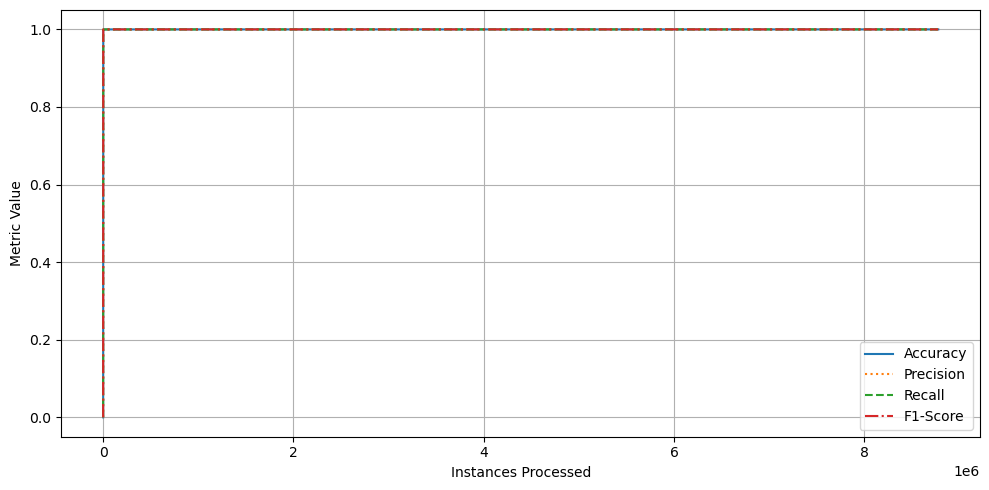

In [8]:
# Plot metric logs
instances = list(range(1, len(metric_logs['accuracy']) + 1))
plt.figure(figsize=(10, 5))
plt.plot(instances, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances, metric_logs['f1_score'], label='F1-Score', linestyle='-.')
for i, drift in enumerate(drift_events):
    plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('metrics_drift_adwin.png', dpi=300)
plt.show()

In [9]:
# Accuracy before and after drift (Figure 16 style)
if drift_events:
    pre_drift_acc = [metric_logs['accuracy'][i - 1] for i in drift_events if i > 0]
    post_drift_acc = [metric_logs['accuracy'][i] for i in drift_events if i < len(metric_logs['accuracy'])]
    drift_labels = [f"Drift {i+1}" for i in range(len(pre_drift_acc))]

    x = range(len(pre_drift_acc))
    bar_width = 0.4
    plt.figure(figsize=(10, 5))
    plt.bar(x, pre_drift_acc, width=bar_width, label='Pre-Drift Accuracy', alpha=0.7)
    plt.bar([i + bar_width for i in x], post_drift_acc, width=bar_width, label='Post-Drift Accuracy', alpha=0.7)

    for i, (pre, post) in enumerate(zip(pre_drift_acc, post_drift_acc)):
        plt.text(i, pre + 0.005, f'{pre:.3f}', ha='center')
        plt.text(i + bar_width, post + 0.005, f'{post:.3f}', ha='center')

    plt.xticks([i + bar_width / 2 for i in x], drift_labels)
    plt.ylabel('Accuracy')
    plt.xlabel('Drift Points')
    plt.title('Model Accuracy Before and After Drift')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.savefig('drift_accuracy_comparison.png', dpi=300)
    plt.show()
else:
    print("No drift events detected, skipping pre/post drift comparison.")

No drift events detected, skipping pre/post drift comparison.


In [10]:
# Final metrics
print(f"Final Accuracy: {metric_accuracy.get():.4f}")
print(f"Final Precision: {metric_precision.get():.4f}")
print(f"Final Recall: {metric_recall.get():.4f}")
print(f"Final F1-Score: {metric_f1.get():.4f}")


Final Accuracy: 1.0000
Final Precision: 1.0000
Final Recall: 1.0000
Final F1-Score: 1.0000
